In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import joblib


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, SimpleRNN
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import l2

In [3]:
df = pd.read_csv("demanda-depurado.csv")

df

,fecha,valor,indicador,region
0,2014-12-31,603.961474,Demanda,peninsular
1,2015-01-01,715.038679,Demanda,canarias
2,2015-01-02,698.648512,Demanda,pais vasco
3,2015-01-03,663.533254,Demanda,la rioja
4,2015-01-04,714.784323,Demanda,cantabria
...,...,...,...,...
3763,2025-04-20,586.636561,Demanda,region de murcia
3764,2025-04-21,658.548194,Demanda,castilla la mancha
3765,2025-04-22,635.731910,Demanda,aragon
3766,2025-04-23,638.813354,Demanda,baleares


In [6]:
df['fecha'] = pd.to_datetime(df['fecha'])

# Filtrar solo demanda
df_demanda = df[df['indicador'] == 'Demanda'].sort_values('fecha')
valores = df_demanda['valor'].values.reshape(-1, 1)

# Normalizar
scaler = MinMaxScaler()
valores_scaled = scaler.fit_transform(valores)

# Crear secuencias para RNN
def crear_secuencias(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 30
X, y = crear_secuencias(valores_scaled, window_size)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


In [58]:

model = Sequential([
    SimpleRNN(10, activation='tanh', return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    SimpleRNN(5, activation='tanh'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

C:\Users\luisa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)             │ (None, 30, 10)              │             120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ (None, 5)                   │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 206 (824.00 B)

 Trainable params: 206 (824.00 B)

 Non-trainable params: 0 (0.00 B)

In [60]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.2869 - val_loss: 0.0163
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0562 - val_loss: 0.0135
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0232 - val_loss: 0.0113
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0179 - val_loss: 0.0089
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0140 - val_loss: 0.0078
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0120 - val_loss: 0.0084
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0119 - val_loss: 0.0090
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0106 - val_loss: 0.0094
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0103 - val_loss: 0.0073
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0108 - val_loss: 0.0083
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0093 - val_loss: 0.0073
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


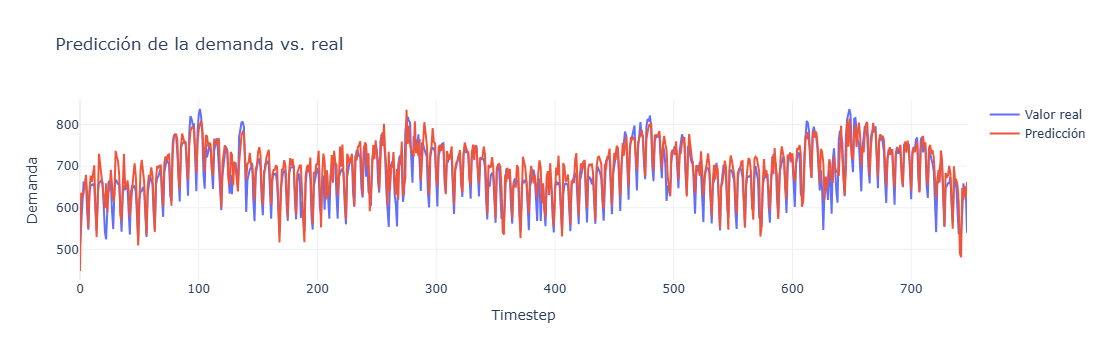

In [62]:
y_pred = model.predict(X_test)

# Invertir la escala (para interpretar los valores reales)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Graficar predicciones vs reales
fig = go.Figure()
fig.add_trace(go.Scatter(y=y_test_inv.flatten(), mode='lines', name='Valor real'))
fig.add_trace(go.Scatter(y=y_pred_inv.flatten(), mode='lines', name='Predicción'))
fig.update_layout(title='Predicción de la demanda vs. real',
                  xaxis_title='Timestep',
                  yaxis_title='Demanda',
                  template='plotly_white')
fig.show()

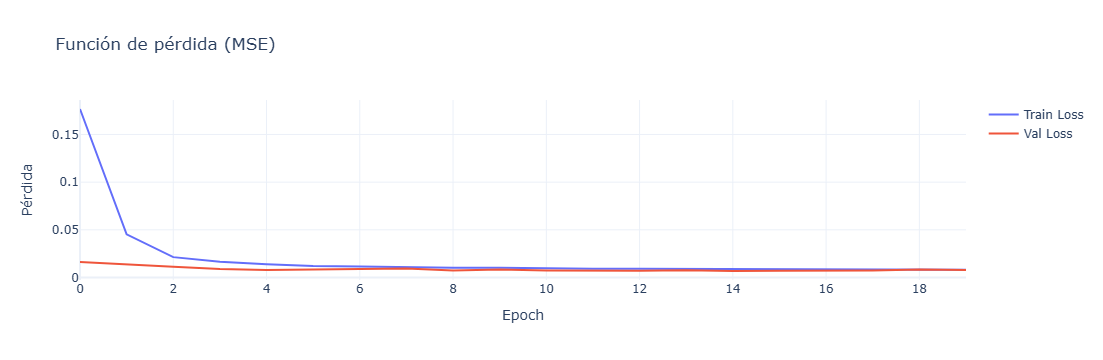

In [64]:
# Gráfico de pérdida
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(y=history.history['loss'], mode='lines', name='Train Loss'))
fig_loss.add_trace(go.Scatter(y=history.history['val_loss'], mode='lines', name='Val Loss'))
fig_loss.update_layout(title='Función de pérdida (MSE)',
                       xaxis_title='Epoch',
                       yaxis_title='Pérdida',
                       template='plotly_white')
fig_loss.show()

In [66]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

MAE: 0.0658
RMSE: 0.0883
R²: 0.7178


In [68]:
model.save("modelo_rnn.keras")
joblib.dump(scaler, "scaler_rnn.pkl")

['scaler_rnn.pkl']

In [70]:
joblib.dump(history.history, "historial_entrenamiento_rnn.pkl")

['historial_entrenamiento_rnn.pkl']

In [74]:
joblib.dump(X_test, "X_test_rnn.pkl")
joblib.dump(y_test, "y_test_rnn.pkl")

['y_test_rnn.pkl']

In [5]:
def predecir_multiple_pasos(modelo, secuencia_inicial, pasos, scaler):
    predicciones = []
    secuencia_actual = secuencia_inicial.copy()

    for _ in range(pasos):
        input_modelo = secuencia_actual.reshape(1, -1, 1)
        pred = modelo.predict(input_modelo, verbose=0)[0]
        predicciones.append(pred)

        # Agregar la predicción y eliminar el primer elemento
        secuencia_actual = np.append(secuencia_actual[1:], [pred], axis=0)

    # Invertir la escala
    predicciones_inv = scaler.inverse_transform(np.array(predicciones).reshape(-1, 1))
    return predicciones_inv.flatten()

In [ ]:
# Usar los últimos valores reales conocidos como punto de partida
secuencia_inicial = valores_scaled[-window_size:]
predicciones_10_dias = predecir_multiple_pasos(model, secuencia_inicial, pasos=10, scaler=scaler)

# Graficar
fig = go.Figure()
fig.add_trace(go.Scatter(y=scaler.inverse_transform(valores_scaled[-60:]).flatten(), mode='lines', name='Histórico reciente'))
fig.add_trace(go.Scatter(y=predicciones_10_dias, mode='lines+markers', name='Predicciones futuras'))
fig.update_layout(title='Predicción multi-step (10 días)',
                  xaxis_title='Timestep',
                  yaxis_title='Demanda',
                  template='plotly_white')
fig.show()